# Spaceship Titanic

- 첫 시도
    - tensorflow를 이용해 활성화함수가 `sigmoid`인 `Dense Layer`을 1개 쌓아 모델을 만들고 손실함수는 `binary cross entropy` 함수, optimizer는`adam`를 이용하였음.
    - 잘 작동하며 결과도 잘 나왔으나 한계점이 분명함. 하이퍼파라미터를 아무리 변경해보아도 val_accuray 기준 0.7~0.8 이상은 절대 안 올라감. 즉 과소적합등의 문제가 아니라 모델 자체의 한계점으로 보임

## Import modules

In [20]:
import os
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Set envs

In [21]:
PATH_INPUT = './data/in/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
    )
except:
    print("NO GPU")

NO GPU


## Get Data

In [22]:
df_train = pd.read_csv('./data/out/preprocessed_data/train_int.csv')
df_test = pd.read_csv('./data/out/preprocessed_data/test_int.csv')

## Train

### Set Input data

In [23]:
exception_cols = ['PassengerId', 'Name']
dependants = ['Transported']
independents = [ i for i in df_train.keys() if i not in dependants and i not in exception_cols ]
# 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'

X = df_train[independents]
Y = df_train[dependants]

In [24]:
X.shape, Y.shape

((8693, 15), (8693, 1))

### Build model

In [25]:
model = tf.keras.Sequential([
    Input(shape=[len(independents)]),
    Dense(128, activation="sigmoid"),
    Dense(64, activation="sigmoid"),
    Dense(32, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(len(dependants), activation="sigmoid")
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               2048      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
optimizer = tf.keras.optimizers.Adam()

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

### Callback Functions

In [28]:
cb_earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, start_from_epoch=50)

chkpoint_path = f'./data/out/{NOW_STR}/monitor/'
if not os.path.exists(chkpoint_path):
    os.makedirs(chkpoint_path)

chkpoint_path += 'weights.h5'

cb_chkpoint = ModelCheckpoint(chkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

### Train model

#### Set Hyper-parameter

In [29]:
hyper_param = {
    "epochs": 200,
    "batch_size": 16,
    "validation_split": 0.1
}

#### Train

In [30]:
history = model.fit(
    X,
    Y,
    epochs=hyper_param['epochs'],
    batch_size=hyper_param['batch_size'],
    verbose=1,
    validation_split=hyper_param['validation_split'],
    callbacks=[cb_earlystopping, cb_chkpoint]
)

Epoch 1/200
485/489 [============================>.] - ETA: 0s - loss: 0.5360 - accuracy: 0.7577
Epoch 1: val_accuracy improved from -inf to 0.77701, saving model to ./data/out/20240110_125949/monitor/weights.h5
489/489 [==============================] - 5s 9ms/step - loss: 0.5358 - accuracy: 0.7578 - val_loss: 0.5027 - val_accuracy: 0.7770
Epoch 2/200
489/489 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7909
Epoch 2: val_accuracy improved from 0.77701 to 0.78161, saving model to ./data/out/20240110_125949/monitor/weights.h5
489/489 [==============================] - 4s 9ms/step - loss: 0.4901 - accuracy: 0.7909 - val_loss: 0.5021 - val_accuracy: 0.7816
Epoch 3/200
489/489 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.7913
Epoch 3: val_accuracy did not improve from 0.78161
489/489 [==============================] - 4s 8ms/step - loss: 0.4804 - accuracy: 0.7913 - val_loss: 0.4916 - val_accuracy: 0.7805
Epoch 4/200
482/489 [===========

## Result

### Model history graph

In [31]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

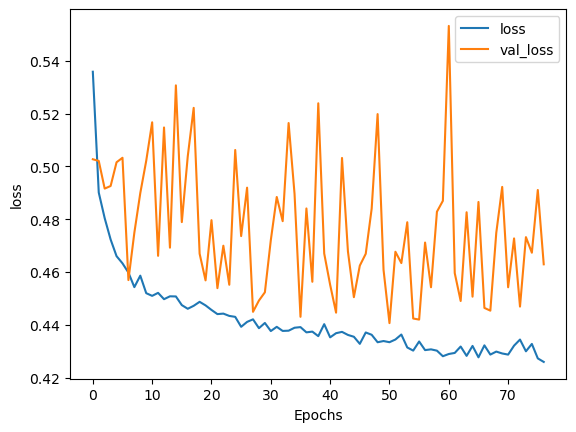

In [32]:
plot_graphs(history, 'loss')

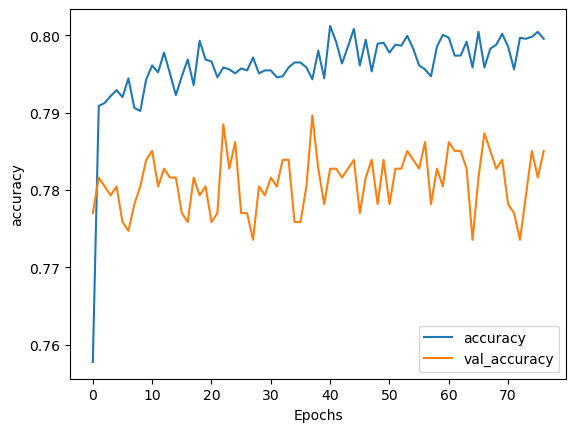

In [33]:
plot_graphs(history, 'accuracy')

### Save result data

In [34]:
data_out_path = f'./data/out/{NOW_STR}/'

if not os.path.exists(data_out_path):
    os.makedirs(data_out_path)

model.load_weights(os.path.join(data_out_path, "monitor", "weights.h5"))
model.save(os.path.join(data_out_path, "models", "model.h5"))

/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Validation

### Predict

In [35]:
df_test.head()

,PassengerId,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0013_01,1,3,27.0,0,0.0,0.0,0.0,0.0,0.0,6,3.0,2,1,0,0
1,0018_01,0,3,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,4.0,2,1,0,0
2,0019_01,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0.0,2,0,1,0
3,0021_01,0,3,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,1.0,2,0,1,0
4,0023_01,0,3,20.0,0,10.0,0.0,635.0,0.0,0.0,5,5.0,2,1,0,0


### Preprocess test data

In [36]:
predictions = model.predict(df_test[independents], batch_size=hyper_param['batch_size'])

268/268 [==============================] - 1s 2ms/step


#### Export prediction to csv file

##### Set Result Data

In [37]:
# 1에 가까우면 -> True, 0에 가까우면 False
predictions = list(map(lambda v: True if v[0] > 0.5 else False, predictions))

In [38]:
output = pd.DataFrame({ "PassengerId": df_test['PassengerId'].to_list(), "Transported": predictions })
output_dir = os.path.join(PATH_OUTPUT_NOW, "predict")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output.to_csv(os.path.join(output_dir, 'predict.csv'), index=False)